<a href="https://colab.research.google.com/github/chrisliii/FINE-452/blob/main/Fama_French.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 6.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=323608080e142d3ad601fddd14f08e7a968d3228074163158ce168d63771469c
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [89]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm

import matplotlib.pyplot as plt

In [ ]:
stock_name = "^GSPC"
ticker = yf.Ticker(stock_name)
#ticker.info
# monthly data
df_ticker_monthly_return = ticker.history(period="max", interval='1mo')
# monthly return
df_ticker_monthly_return['MonthlyReturn'] = 100*( (df_ticker_monthly_return['Close'].shift(-1)).div(df_ticker_monthly_return['Close']) - 1)
df_ticker_monthly_return['MonthlyReturn'] = df_ticker_monthly_return['MonthlyReturn'].shift(1)
df_ticker_monthly_return = df_ticker_monthly_return.dropna()
#date to string
df_ticker_monthly_return = df_ticker_monthly_return.reset_index()

df_ticker_monthly_return.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn
0,192801,17.76,17.76,17.26,17.57,0,0,0,-0.509626
1,192802,17.53,17.63,16.95,17.26,0,0,0,-1.764371
2,192803,17.30,19.28,17.30,19.28,0,0,0,11.703360
3,192804,18.91,19.75,18.91,19.75,0,0,0,2.437759
4,192805,19.78,20.44,19.36,20.00,0,0,0,1.265823


In [24]:
stock_name = "BUD"
ticker = yf.Ticker(stock_name)
#ticker.info
# monthly data
df_ticker_monthly_return = ticker.history(period="max", interval='1mo')
# process Dividends
df_ticker_monthly_return = df_ticker_monthly_return.dropna(how='all')
df_ticker_monthly_return['Dividends'] = df_ticker_monthly_return['Dividends'].shift(1)
df_ticker_monthly_return = df_ticker_monthly_return.dropna()
# monthly return
df_ticker_monthly_return['MonthlyReturn'] = 100*( (df_ticker_monthly_return['Close'].shift(-1)+df_ticker_monthly_return['Dividends'].shift(-1)).div(df_ticker_monthly_return['Close']) - 1)
df_ticker_monthly_return = df_ticker_monthly_return.dropna()
#date to string
df_ticker_monthly_return = df_ticker_monthly_return.reset_index()
df_ticker_monthly_return['Date'] = df_ticker_monthly_return['Date'].apply(lambda x: x.strftime('%Y%m'))

df_ticker_monthly_return.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn
0,200908,29.760850,32.774607,28.668363,32.699265,552600.0,0.0,0,5.852542
1,200909,32.021172,36.097279,31.192390,34.613003,5235600.0,0.0,0,2.699174
2,200910,33.859563,39.585703,32.714334,35.547268,6638200.0,0.0,0,6.591756
3,200911,36.089738,39.593228,34.869164,37.890457,9535400.0,0.0,0,3.459936
4,200912,38.425401,40.452152,37.860322,39.201443,4094100.0,0.0,0,-4.305204


In [27]:
df_FF_Research = pd.read_csv('F-F_Research_Data_Factors.CSV', encoding="utf-8", skipinitialspace=True)
df_FF_Research.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']
df_FF_Research = df_FF_Research.dropna()
df_FF_Research['Mkt-RF'] = df_FF_Research['Mkt-RF'].astype(float)
df_FF_Research['SMB'] = df_FF_Research['SMB'].astype(float)
df_FF_Research['HML'] = df_FF_Research['HML'].astype(float)

df_FF_Research.head()

,Date,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.30,-2.87,0.22
1,192608,2.64,-1.40,4.19,0.25
2,192609,0.36,-1.32,0.01,0.23
3,192610,-3.24,0.04,0.51,0.32
4,192611,2.53,-0.20,-0.35,0.31


In [ ]:
# Before merger
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = df_ticker_FF['Date'].astype(int)
df_ticker_FF = df_ticker_FF[(df_ticker_FF.Date >= 201009) & 
                            (df_ticker_FF.Date <= 201509)]

model = sm.OLS(df_ticker_FF['MonthlyReturn'], sm.add_constant(
    df_ticker_FF[['Mkt-RF', 'SMB', 'HML']].values))
result = model.fit()
print(stock_name + '\n')
print (result.params)
print(result.summary())

BUD

const    0.429189
x1       1.016587
x2      -0.338834
x3      -0.529946
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          MonthlyReturn   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     12.31
Date:                Wed, 28 Oct 2020   Prob (F-statistic):           2.57e-06
Time:                        04:59:11   Log-Likelihood:                -175.71
No. Observations:                  61   AIC:                             359.4
Df Residuals:                      57   BIC:                             367.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
# After merger
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = df_ticker_FF['Date'].astype(int)
df_ticker_FF = df_ticker_FF[(df_ticker_FF.Date >= 201511) & 
                            (df_ticker_FF.Date <= 202011)]

model = sm.OLS(df_ticker_FF['MonthlyReturn'], sm.add_constant(
    df_ticker_FF[['Mkt-RF', 'SMB', 'HML']].values))
result = model.fit()
print(stock_name + '\n')
print (result.params)
print(result.summary())

BUD

const   -1.665961
x1       1.312990
x2      -0.389646
x3       0.122467
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          MonthlyReturn   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     12.39
Date:                Wed, 28 Oct 2020   Prob (F-statistic):           2.97e-06
Time:                        04:59:12   Log-Likelihood:                -188.25
No. Observations:                  57   AIC:                             384.5
Df Residuals:                      53   BIC:                             392.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [ ]:
df_ticker_monthly_return.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn
405,202007,434.799988,470.609985,416.290009,444.320007,54649300.0,0.0,0.0,2.069792
406,202008,449.839996,533.700012,431.589996,513.390015,54517800.0,0.0,0.0,15.545104
407,202009,515.000000,536.880005,452.519989,490.429993,84770900.0,0.0,0.0,-4.472238
408,202010,497.429993,519.599976,470.130005,475.200012,38118500.0,0.0,0.0,-3.105434
409,202010,479.779999,481.665009,473.470001,478.559998,1896459.0,0.0,0.0,0.707068


In [69]:
# data prep
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m')

# sample period
date_begin_sample = datetime(2010, 10, 1)
date_end_sample = datetime(2020, 10, 1)


# CAPM out of sample
df_ticker_FF[(df_ticker_FF.Date == datetime(2020, 6, 1,0,0))]['Mkt-RF'].shape





(1,)

In [84]:
df_ticker_FF.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn
127,2020-03-01,56.917395,58.085846,32.261114,43.688160,111428900.0,0.000000,0,5.439713,-13.39,-5.15,-14.17,0.12,-1.322747
128,2020-04-01,43.945617,49.451194,40.707623,46.064671,54798400.0,0.000000,0,0.773868,13.65,2.76,-1.18,0.00,-3.277276
129,2020-05-01,45.945849,47.876760,37.558750,46.421150,63898900.0,0.000000,0,5.162106,5.58,2.46,-4.92,0.01,-1.911890
130,2020-06-01,47.361850,58.085846,46.995469,48.817459,70354500.0,0.000000,0,12.658279,2.45,2.68,-2.19,0.01,-1.390388
131,2020-07-01,48.410000,58.549999,48.410000,54.430000,45817800.0,0.566909,0,6.834468,5.77,-2.31,-1.27,0.01,-1.326071


In [91]:
# data prep
df_ticker_FF = pd.merge(df_ticker_monthly_return, df_FF_Research, on='Date')
df_ticker_FF['Date'] = pd.to_datetime(df_ticker_FF['Date'], format='%Y%m')

# sample period
begin_date = datetime(2010, 10, 1)
end_date = datetime(2020, 7, 1)
sample_period = 36

# CAPM out of sample
sample_date = begin_date
while sample_date <= end_date:
  df_ticker_FF_sample = df_ticker_FF[(df_ticker_FF.Date >= (sample_date - relativedelta(months=sample_period)) ) & 
                                     (df_ticker_FF.Date < sample_date)].copy()
  CAPM_model = sm.OLS(df_ticker_FF_sample['MonthlyReturn'], sm.add_constant(df_ticker_FF_sample[['Mkt-RF']].values))
  CAPM_result = CAPM_model.fit()
  #print(stock_name + '\n')
  #print (result.params)
  #print(CAPM_result.summary())

  # predict 
  sample_input = df_ticker_FF[(df_ticker_FF.Date == sample_date)]
  sample_input = sample_input['Mkt-RF'].values[0]
  sample_pred =  CAPM_result.predict([1,sample_input])
  #print(sample_input)
  #print(sample_pred)
  df_ticker_FF.loc[df_ticker_FF.Date == sample_date, 'PredReturn'] = sample_pred[0]

  # next sample
  sample_date = sample_date + relativedelta(months=1)


df_ticker_FF = df_ticker_FF.dropna()

df_ticker_FF.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn
14,2010-10-01,44.997546,49.322913,43.642062,47.898895,25527800.0,0.0,0,-12.655020,3.88,1.13,-2.61,0.01,2.129812
15,2010-11-01,48.195879,48.599477,41.479373,41.837280,24626900.0,0.0,0,3.913373,0.60,3.71,-0.90,0.01,2.371387
16,2010-12-01,42.507413,44.548256,42.400802,43.474529,20067700.0,0.0,0,-3.117881,6.82,0.68,3.81,0.01,-0.279819
17,2011-01-01,43.885745,44.837631,41.814441,42.119045,19419700.0,0.0,0,1.301727,1.99,-2.47,0.81,0.01,1.683642
18,2011-02-01,42.294183,43.261299,41.426063,42.667320,30938900.0,0.0,0,2.034648,3.49,1.53,1.09,0.01,0.945568


In [101]:
df_ticker_FF['AbsEpsilon'] = abs(df_ticker_FF.MonthlyReturn - df_ticker_FF.PredReturn)

df_ticker_FF['RollingEpsilon'] = df_ticker_FF.AbsEpsilon.rolling(20).mean()

df_ticker_FF.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,MonthlyReturn,Mkt-RF,SMB,HML,RF,PredReturn,AbsEpsilon,RollingEpsilon
14,2010-10-01,44.997546,49.322913,43.642062,47.898895,25527800.0,0.0,0,-12.655020,3.88,1.13,-2.61,0.01,2.129812,14.784833,NaN
15,2010-11-01,48.195879,48.599477,41.479373,41.837280,24626900.0,0.0,0,3.913373,0.60,3.71,-0.90,0.01,2.371387,1.541986,NaN
16,2010-12-01,42.507413,44.548256,42.400802,43.474529,20067700.0,0.0,0,-3.117881,6.82,0.68,3.81,0.01,-0.279819,2.838062,NaN
17,2011-01-01,43.885745,44.837631,41.814441,42.119045,19419700.0,0.0,0,1.301727,1.99,-2.47,0.81,0.01,1.683642,0.381915,NaN
18,2011-02-01,42.294183,43.261299,41.426063,42.667320,30938900.0,0.0,0,2.034648,3.49,1.53,1.09,0.01,0.945568,1.089080,NaN


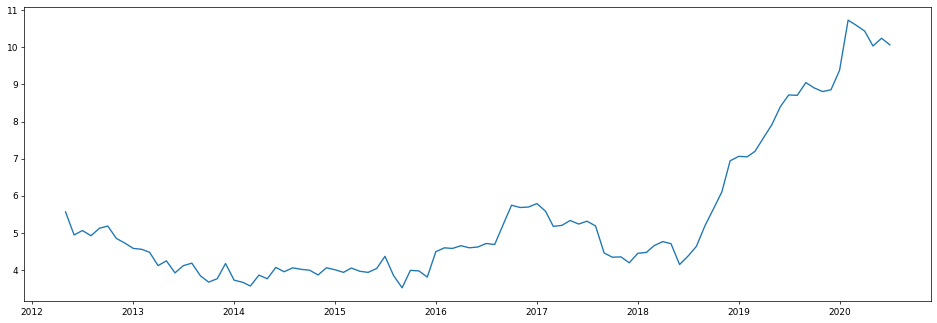

In [102]:
plt.figure(dpi=65, figsize=(18,6))                
plt.plot(df_ticker_FF.Date, df_ticker_FF.RollingEpsilon)              
plt.show()